# Gaia Field Stars (CMD)

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from astropy.table import QTable, Column
from astropy import units as u

from matplotlib.patches import Rectangle, Circle, Ellipse, Polygon

from astroquery.gaia import Gaia

---
# Instructions

The goal of this assignment is to demonstrate your python skills in making a color-magnitude diagram from Gaia data.

This ideas and techniques used in this assignment can be found in the `Python_Plotting_Annotate` notebook

Your first step is to pick a point in space near one the the [**galactic poles**](https://en.wikipedia.org/wiki/Galactic_coordinate_system#Definition). 

The reason for this is that we want to pick a region that has little gas and dust. This gas and dust effects the colors of observed object making
them appear more red. We want to avoid this reddening.

#### Pick and RA and a DEC near one of the galacic poles. You do not need to be exactly at the pole, +/- 5 deg is fine.

### Enter the coordinates of the center of your field

  - The coordinates need to be in **degrees**
  - Remember: 1 hour of RA = 15 deg, 1 min of RA = 0.25 deg

In [2]:
# North Pole
my_object_ra = 192.85
my_object_dec = 27.13

## Get the the [Gaia data](https://www.cosmos.esa.int/web/gaia/dr3) for your field

- Adjust the radius of your search window until you get at least 3000 objects (more is fine).
- You want the columns: `source_id, ra, dec, phot_g_mean_mag, bp_rp, parallax, parallax_over_error`
    - `parallax_over_error` > 8
    - `g_mag` and `bp_rp` should not be null


In [3]:
query = f"""
SELECT TOP 3000
source_id, ra, dec, phot_g_mean_mag, bp_rp, parallax, parallax_over_error
FROM gaiadr3.gaia_source_lite
WHERE
    DISTANCE( POINT({my_object_ra}, {my_object_dec}), POINT(ra, dec) ) < 1.33012
    AND parallax_over_error > 8
    AND phot_g_mean_mag IS NOT NULL
    AND bp_rp IS NOT NULL
ORDER BY bp_rp ASC
"""

In [4]:
job_query = Gaia.launch_job(query)
#print(job_query)

star_table = job_query.get_results()
#star_table

### Use `parallax` and `phot_g_mean_mag` to get **distance** (in pc) and the **absolute magnitude** ($G_{M}$)

- Add them as columns to the data table

In [5]:
star_table['distance'] = 1000 / star_table['parallax']
#star_table

In [6]:
def abgm(app_mag, dist):
    return (app_mag - 5*np.log10(dist/10))

star_table['abs_g_mag'] = abgm(
    app_mag = star_table['phot_g_mean_mag'], 
    dist = star_table['distance']
    )
#star_table

---

## Make a subset of your data table that contains the data for all of the white dwarf stars in your field

- ### You will need information from the CMD on the back your [Gaia Info Sheet](./Info/GaiaInfo.pdf).
- ### You will need to make a cut based on the color (`bp_rp`) and Absolute magnitude (G$_M$)

In [7]:
white_dwarfs = star_table[
    (star_table['bp_rp'] < 1.5) &
    (star_table['abs_g_mag'] > 9.5)
]

In [8]:
#white_dwarfs

### How many of your objects are white dwarf stars?

In [9]:
print(f"There are {len(np.unique(white_dwarfs['source_id']))} white dwarfs.")

There are 19 white dwarfs.


---

# Make an annotated color magnitude diagram (BP-RP vs. $G_{M}$) of your field.

- A figure size of 15 in x 15 in
- Both axes labeled
- A title for the figure
- The main sequence indicated in some way
- A symbol and label placed at the position of the Sun (**BP-RP** = 0.82, $G_{M}$ = 4.67)
- White dwarf stars plotted with a different symbol, color, and size
- 100 nearest stars plotted with a different symbol, color, and size
- 100 farthest stars plotted with a different symbol, color, and size
- **Use annotations (arrows, shapes, text) to make everything clear**

In [10]:
# star_table['bp_rp'].unit = u.angstrom
# star_table['abs_g_mag'].unit = u.mag

# white_dwarfs['bp_rp'].unit = u.angstrom
# white_dwarfs['abs_g_mag'].unit = u.mag

In [11]:
star_table.sort('distance')

In [12]:
nearest_stars = star_table[0:100]
#nearest_stars

In [13]:
furthest_stars = star_table[::-1][0:100]
#furthest_stars

In [14]:
np.ptp(star_table['bp_rp'])

4.5162745

In [15]:
np.ptp(star_table['abs_g_mag'])

18.136526802148406

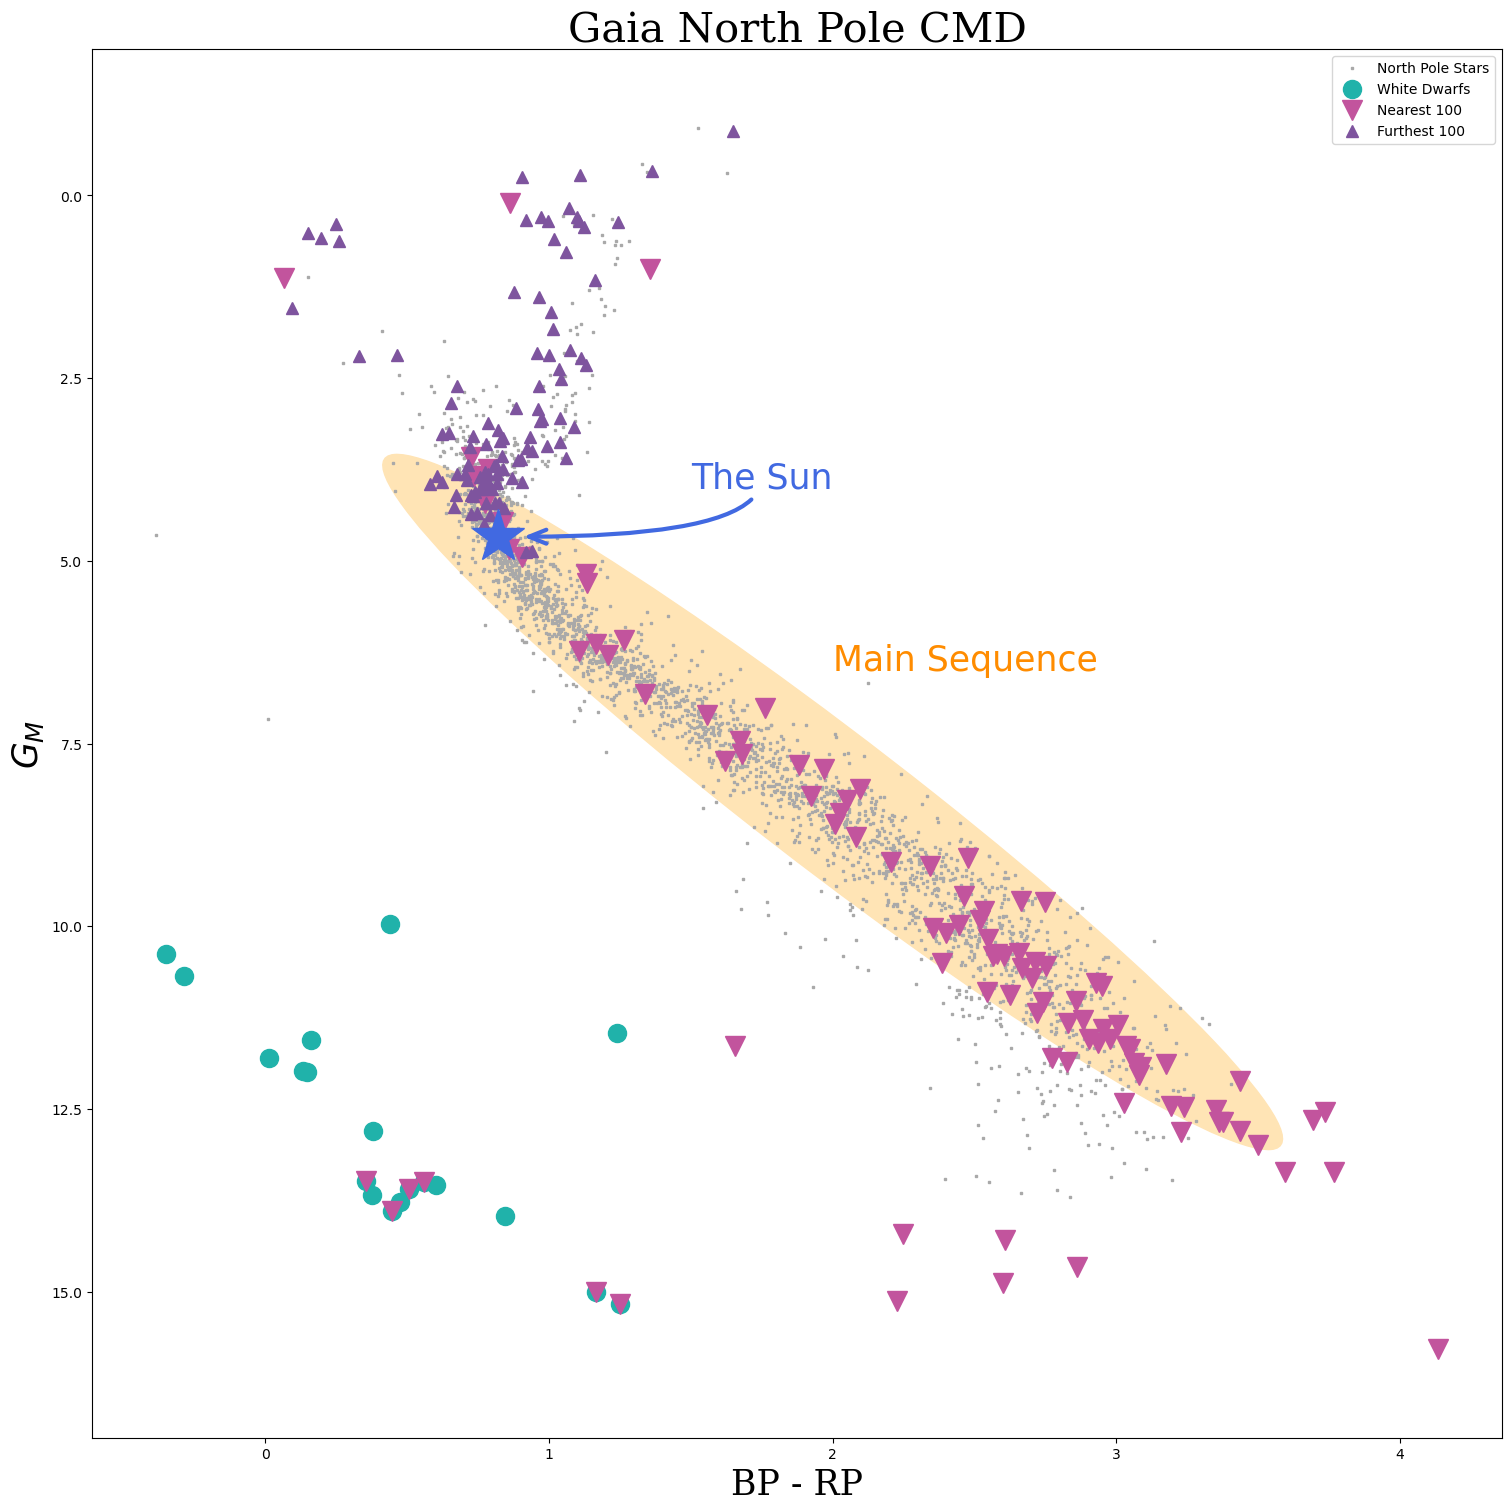

In [16]:
fig, cmd = plt.subplots(
    figsize = (15, 15), 
    constrained_layout = True
)

# Magnitudes are backwards

cmd.set_ylim(-2, 17)
cmd.invert_yaxis()

### Axis Labels ###

cmd.set_xlabel("BP - RP",
              fontfamily = 'serif',
              fontsize = 25)

cmd.set_ylabel(r"$G_{M}$",
              fontfamily = 'serif',
              fontsize = 25)

cmd.set_title(f"Gaia North Pole CMD",
             fontfamily = 'serif',
             fontsize = 30)

### Plot Data ###

cmd.plot(star_table['bp_rp'], star_table['abs_g_mag'],
        color = "darkgray",
        marker = "s",
        linestyle = "None",
        markersize = 2,
        label = "North Pole Stars"
        );

cmd.plot(white_dwarfs['bp_rp'], white_dwarfs['abs_g_mag'],
        color = "#20B2AA",
        marker = "o",
        linestyle = "None",
        markersize = 13,
        label = "White Dwarfs"
        );

cmd.plot(nearest_stars['bp_rp'], nearest_stars['abs_g_mag'],
        color = "#c2549d",
        marker = "v", # triangle down
        linestyle = "None",
        markersize = 15,
        label = "Nearest 100"
        );

cmd.plot(furthest_stars['bp_rp'], furthest_stars['abs_g_mag'],
        color = "#7e549e",
        marker = "^", # triangle up
        linestyle = "None",
        markersize = 8,
        label = "Furthest 100"
        );

cmd.legend(loc = 0)

### Labelling the Sun ###

cmd.plot(0.82, 4.67,
         color = "#4169E1",
         marker = "*",
         markersize = 40,
         label = "The Sun"
        );

cmd.annotate('The Sun',
             xy = (0.9, 4.67),
             xytext = (1.5, 4),
             fontsize = 25,
             color = '#4169E1',
             arrowprops = {'color' : '#4169E1',
                           'linewidth' : 3,
                           'arrowstyle' : '->, head_length = 0.5, head_width = 0.2',
                           'connectionstyle' : 'angle3, angleA = 90, angleB = 0'}
            );


### Adding Shapes ###

mainseq_shape = Ellipse((2, 8.3),
                       width = 0.75,
                       height = 10,
                       angle = -18,
                       color = '#FFE4B5')

cmd.add_patch(mainseq_shape);

cmd.annotate('Main Sequence',
             xy = (1.75, 7.5),
             xytext = (2, 6.5),
             fontsize = 25,
             color = '#FF8C00',
             );

---

### Save and download a PNG version of your figure. You will need this for the final assignment of the class.

- Feel free to change the name of the file if you wish.

In [17]:
fig.savefig('My_Cool_Plot.png', bbox_inches='tight')

### Due Wed Feb 7 - 1 pm
- `File -> Download as -> HTML (.html)`
- `upload your .html file to the class Canvas page`